<a href="https://colab.research.google.com/github/jugs123/NSL-KDD-GANS/blob/main/NSL_KDD_2_with_SM_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Changes: 
1. Includes similarity measurement
2. Dimension of generator noise vector - 9 (Reference taken from IDSGAN paper)
3. Includes minimum, mean and maximum values

In [38]:
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.spatial.distance import cosine
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

## EDA and Preprocessing

In [39]:
col_names = ["duration", "protocol_type", "service", "flag", "src_bytes",
             "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
             "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root",
             "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
             "is_hot_login", "is_guest_login", "count", "srv_count", "serror_rate",
             "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
             "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
             "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
             "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
             "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label", "score"]

PATH = "/content/drive/MyDrive/NSL KDD/Datasets/KDDTrain+.txt"
ori_train_df = pd.read_csv(PATH, names=col_names)
ori_train_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_hot_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,score
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [40]:
train_df = ori_train_df.copy()
ori_train_df.describe(include="all")

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_hot_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,score
count,125973.00000,125973,125973,125973,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.0,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973,125973.000000
unique,NaN,3,70,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23,NaN
top,NaN,tcp,http,SF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,normal,NaN
freq,NaN,102689,40338,74945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67343,NaN
mean,287.14465,NaN,NaN,NaN,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,0.001342,0.001103,0.302192,0.012669,0.000413,0.004096,0.0,0.000008,0.009423,84.107555,27.737888,0.284485,0.282485,0.119958,0.121183,0.660928,0.063053,0.097322,182.148945,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240,NaN,19.504060
std,2604.51531,NaN,NaN,NaN,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,0.036603,0.045154,24.399618,0.483935,0.022181,0.099370,0.0,0.002817,0.096612,114.508607,72.635840,0.446456,0.447022,0.320436,0.323647,0.439623,0.180314,0.259830,99.206213,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459,NaN,2.291503
min,0.00000,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
25%,0.00000,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,18.000000
50%,0.00000,NaN,NaN,NaN,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,20.000000
75%,0.00000,NaN,NaN,NaN,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,143.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000,NaN,21.0000

### Dropping some of the columns

In [41]:
ori_train_df["protocol_type"].value_counts()

tcp     102689
udp      14993
icmp      8291
Name: protocol_type, dtype: int64

In [42]:
ori_train_df["service"].value_counts()

http         40338
private      21853
domain_u      9043
smtp          7313
ftp_data      6860
             ...  
tftp_u           3
http_8001        2
aol              2
harvest          2
http_2784        1
Name: service, Length: 70, dtype: int64

In [43]:
ori_train_df["flag"].value_counts()

SF        74945
S0        34851
REJ       11233
RSTR       2421
RSTO       1562
S1          365
SH          271
S2          127
RSTOS0      103
S3           49
OTH          46
Name: flag, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


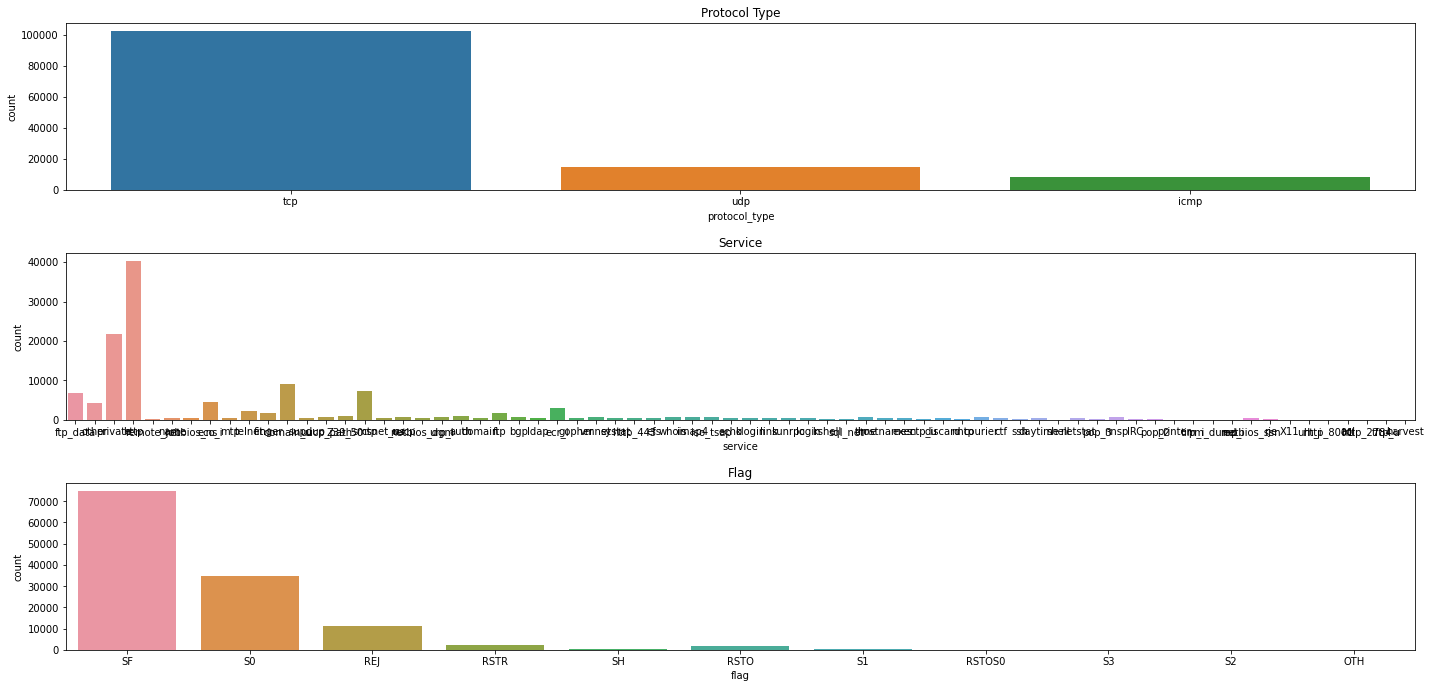

In [44]:
fig, axs = plt.subplots(3, 1, figsize=(20, 10))
axs[0].set_title("Protocol Type")
axs[1].set_title("Service")
axs[2].set_title("Flag")
fig.tight_layout(pad=3.0)

sns.countplot(ori_train_df["protocol_type"], ax=axs[0])
sns.countplot(ori_train_df["service"], ax=axs[1])
sns.countplot(ori_train_df["flag"], ax=axs[2])

In [45]:
# Since there is a huge differences in the distributions, dropping the categorical columns
train_df.drop(["protocol_type", "service", "flag"], inplace=True, axis=1)
train_df.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_hot_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,score
0,0,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [46]:
train_df.describe(include="all")

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_hot_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,score
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.0,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973,125973.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,normal,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67343,NaN
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,0.001342,0.001103,0.302192,0.012669,0.000413,0.004096,0.0,0.000008,0.009423,84.107555,27.737888,0.284485,0.282485,0.119958,0.121183,0.660928,0.063053,0.097322,182.148945,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240,NaN,19.504060
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,0.036603,0.045154,24.399618,0.483935,0.022181,0.099370,0.0,0.002817,0.096612,114.508607,72.635840,0.446456,0.447022,0.320436,0.323647,0.439623,0.180314,0.259830,99.206213,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459,NaN,2.291503
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,18.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,20.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,143.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000,NaN,21.000000


In [47]:
train_df["land"].value_counts()

0    125948
1        25
Name: land, dtype: int64

In [48]:
train_df["root_shell"].value_counts()

0    125804
1       169
Name: root_shell, dtype: int64

In [49]:
train_df["su_attempted"].value_counts()

0    125893
2        59
1        21
Name: su_attempted, dtype: int64

In [50]:
train_df["is_hot_login"].value_counts()

0    125972
1         1
Name: is_hot_login, dtype: int64

In [51]:
train_df["is_guest_login"].value_counts()

0    124786
1      1187
Name: is_guest_login, dtype: int64

In [52]:
train_df["label"].value_counts()

normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: label, dtype: int64

### '0' for normal traffic and '1' for malicious traffic

In [53]:
train_df["status"] = train_df["label"].map(lambda x: 0 if x == "normal" else 1)
train_df["status"].value_counts()

0    67343
1    58630
Name: status, dtype: int64

In [54]:
del_cols = ["land", "root_shell", "su_attempted", "is_hot_login", "is_guest_login", "label", "score"]
train_df.drop(del_cols, inplace=True, axis=1)

### Normalize the dataset (Min - Max)

In [55]:
norm_train_df = train_df.copy()

In [56]:
norm_cols = ["duration", "src_bytes", "dst_bytes", "hot", "num_compromised",
             "num_root", "num_file_creations", "count", "srv_count", "dst_host_count",
             "dst_host_srv_count"]

norm_train_df[norm_cols] = (train_df[norm_cols] - train_df[norm_cols].min()) / (train_df[norm_cols].max() - train_df[norm_cols].min())


### Final Updated dataset info

In [57]:
train_df.head()

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,status
0,0,491,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0
1,0,146,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1
3,0,232,8153,0,0,0,0,1,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0
4,0,199,420,0,0,0,0,1,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0


In [58]:
train_df.describe(include="all")

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,status
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.0,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,0.302192,0.012669,0.000413,0.004096,0.0,84.107555,27.737888,0.284485,0.282485,0.119958,0.121183,0.660928,0.063053,0.097322,182.148945,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240,0.465417
std,2604.51531,5.870331e+06,4.021269e+06,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,24.399618,0.483935,0.022181,0.099370,0.0,114.508607,72.635840,0.446456,0.447022,0.320436,0.323647,0.439623,0.180314,0.259830,99.206213,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459,0.498805
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,143.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000,1.000000
max,42908.00000,1.379964e+09,1.309937e+09,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,7468.000000,43.000000,2.000000,9.000000,0.0,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [59]:
norm_train_df.head()

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,status
0,0.0,3.558064e-07,0.000000e+00,0,0,0.0,0,0,0.0,0.0,0.0,0,0,0,0.003914,0.003914,0.0,0.0,0.0,0.0,1.00,0.00,0.00,0.588235,0.098039,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0
1,0.0,1.057999e-07,0.000000e+00,0,0,0.0,0,0,0.0,0.0,0.0,0,0,0,0.025440,0.001957,0.0,0.0,0.0,0.0,0.08,0.15,0.00,1.000000,0.003922,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0
2,0.0,0.000000e+00,0.000000e+00,0,0,0.0,0,0,0.0,0.0,0.0,0,0,0,0.240705,0.011742,1.0,1.0,0.0,0.0,0.05,0.07,0.00,1.000000,0.101961,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1
3,0.0,1.681203e-07,6.223962e-06,0,0,0.0,0,1,0.0,0.0,0.0,0,0,0,0.009785,0.009785,0.2,0.2,0.0,0.0,1.00,0.00,0.00,0.117647,1.000000,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0
4,0.0,1.442067e-07,3.206260e-07,0,0,0.0,0,1,0.0,0.0,0.0,0,0,0,0.058708,0.062622,0.0,0.0,0.0,0.0,1.00,0.00,0.09,1.000000,1.000000,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0


In [60]:
norm_train_df.describe(include="all")

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,status
count,125973.000000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.0,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,0.006692,3.302024e-05,1.509928e-05,0.022687,0.000111,0.002655,0.001222,0.395736,0.000037,0.000040,0.000295,0.000413,0.004096,0.0,0.164594,0.054282,0.284485,0.282485,0.119958,0.121183,0.660928,0.063053,0.097322,0.714310,0.453541,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240,0.465417
std,0.060700,4.253974e-03,3.069818e-03,0.253530,0.014366,0.027922,0.045239,0.489010,0.003201,0.003267,0.011254,0.022181,0.099370,0.0,0.224087,0.142145,0.446456,0.447022,0.320436,0.323647,0.439623,0.180314,0.259830,0.389044,0.434128,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459,0.498805
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.003914,0.003914,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,0.321569,0.039216,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3.188489e-08,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.027397,0.015656,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.247059,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.000052e-07,3.939120e-07,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.279843,0.035225,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,1.000000,1.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000e+00,1.000000e+00,3.000000,3.000000,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,2.000000,9.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [61]:
norm_train_df.shape

(125973, 34)

In [62]:
train_df.to_csv("/content/drive/MyDrive/NSL KDD/Updated dataset/updated_not_normalized.csv", index=False)
norm_train_df.to_csv("/content/drive/MyDrive/NSL KDD/Updated dataset/updated_normalized.csv", index=False)

## Model definitions

In [63]:
# Dataset Shape = (125973, 34)

def build_generator(input_size=100, output_size=33) :
    generator = Sequential()
    generator.add(Dense(input_size, activation="relu", input_shape=[input_size]))
    generator.add(Dense(input_size * 2, activation="relu"))
    generator.add(Dropout(0.2))
    generator.add(Dense(input_size * 2, activation="relu"))
    generator.add(Dropout(0.2))
    generator.add(Dense(input_size * 3, activation="relu"))
    generator.add(Dropout(0.2))
    generator.add(Dense(output_size, activation="relu"))
    return generator


def build_discriminator(input_size=33) :
    discriminator = Sequential()
    discriminator.add(Dense(input_size, activation="relu", input_shape=[input_size]))
    discriminator.add(Dense(input_size * 2, activation="relu"))
    discriminator.add(Dropout(0.2))
    discriminator.add(Dense(input_size * 2, activation="relu"))
    discriminator.add(Dropout(0.1))
    discriminator.add(Dense(1, activation="sigmoid"))
    return discriminator

## Similarity analysis Code

In [64]:
# For measuring similarity between Generated malicious traffic (using generator) and the normal traffic from the dataset

euc_dist_dict = {}
cosine_sim_dict = {}
ori_normal_traf = norm_train_df[norm_train_df["status"]==0]
ori_normal_traf.drop(["status"], inplace=True, axis=1)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [65]:
def get_mean_euc_dist(generated_traffic, ori_traffic=ori_normal_traf) :
    euc_dist = 0
    num_rows = generated_traffic.shape[0]
    for i in range(ori_traffic.shape[0]) :
        euc_dist += np.linalg.norm(generated_traffic - ori_traffic.iloc[i].values.reshape(num_rows, 1))

    return euc_dist / ori_traffic.shape[0]

def get_mean_cosine_sim(generated_traffic, ori_traffic=ori_normal_traf) :
    cos_dist = 0
    num_rows = generated_traffic.shape[0]
    for i in range(ori_traffic.shape[0]) :
        cos_dist += cosine(generated_traffic, ori_traffic.iloc[i].values.reshape(num_rows, 1)) 

    cos_dist /= ori_traffic.shape[0]
    return (1 - cos_dist)


## Training

In [66]:
norm_train_df.head()

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,status
0,0.0,3.558064e-07,0.000000e+00,0,0,0.0,0,0,0.0,0.0,0.0,0,0,0,0.003914,0.003914,0.0,0.0,0.0,0.0,1.00,0.00,0.00,0.588235,0.098039,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0
1,0.0,1.057999e-07,0.000000e+00,0,0,0.0,0,0,0.0,0.0,0.0,0,0,0,0.025440,0.001957,0.0,0.0,0.0,0.0,0.08,0.15,0.00,1.000000,0.003922,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0
2,0.0,0.000000e+00,0.000000e+00,0,0,0.0,0,0,0.0,0.0,0.0,0,0,0,0.240705,0.011742,1.0,1.0,0.0,0.0,0.05,0.07,0.00,1.000000,0.101961,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1
3,0.0,1.681203e-07,6.223962e-06,0,0,0.0,0,1,0.0,0.0,0.0,0,0,0,0.009785,0.009785,0.2,0.2,0.0,0.0,1.00,0.00,0.00,0.117647,1.000000,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0
4,0.0,1.442067e-07,3.206260e-07,0,0,0.0,0,1,0.0,0.0,0.0,0,0,0,0.058708,0.062622,0.0,0.0,0.0,0.0,1.00,0.00,0.09,1.000000,1.000000,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0


In [67]:
epochs = 100
batch_size = 64
noise_shape = 9

disc_loss_normal_dict = {}
disc_loss_mal_dict = {}
gan_loss_dict = {}

X_train_normal = norm_train_df[norm_train_df["status"]==0]
X_train_normal.drop(["status"], inplace=True, axis=1)
X_train_normal.reset_index(drop=True, inplace=True)
X_train_normal.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0.0,3.558064e-07,0.000000e+00,0,0,0.0,0,0,0.0,0.0,0.0,0,0,0,0.003914,0.003914,0.0,0.0,0.0,0.0,1.00,0.00,0.00,0.588235,0.098039,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00
1,0.0,1.057999e-07,0.000000e+00,0,0,0.0,0,0,0.0,0.0,0.0,0,0,0,0.025440,0.001957,0.0,0.0,0.0,0.0,0.08,0.15,0.00,1.000000,0.003922,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00
2,0.0,1.681203e-07,6.223962e-06,0,0,0.0,0,1,0.0,0.0,0.0,0,0,0,0.009785,0.009785,0.2,0.2,0.0,0.0,1.00,0.00,0.00,0.117647,1.000000,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01
3,0.0,1.442067e-07,3.206260e-07,0,0,0.0,0,1,0.0,0.0,0.0,0,0,0,0.058708,0.062622,0.0,0.0,0.0,0.0,1.00,0.00,0.09,1.000000,1.000000,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.0,2.079765e-07,1.718403e-06,0,0,0.0,0,1,0.0,0.0,0.0,0,0,0,0.005871,0.013699,0.0,0.0,0.0,0.0,1.00,0.00,0.43,0.031373,0.858824,1.00,0.00,0.12,0.03,0.00,0.00,0.00,0.00


In [68]:
generator = build_generator(input_size=noise_shape)
discriminator = build_discriminator()

discriminator.compile(optimizer='adam', loss='binary_crossentropy')
discriminator.trainable = False

gan = Sequential([generator, discriminator])
gan.compile(optimizer='adam', loss='binary_crossentropy')

### Model summaries

In [69]:
generator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 9)                 90        
_________________________________________________________________
dense_10 (Dense)             (None, 18)                180       
_________________________________________________________________
dropout_5 (Dropout)          (None, 18)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 18)                342       
_________________________________________________________________
dropout_6 (Dropout)          (None, 18)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 27)                513       
_________________________________________________________________
dropout_7 (Dropout)          (None, 27)               

In [70]:
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 33)                1122      
_________________________________________________________________
dense_15 (Dense)             (None, 66)                2244      
_________________________________________________________________
dropout_8 (Dropout)          (None, 66)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 66)                4422      
_________________________________________________________________
dropout_9 (Dropout)          (None, 66)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 67        
Total params: 7,855
Trainable params: 0
Non-trainable params: 7,855
____________________________________________________

In [71]:
gan.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 33)                2049      
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 7855      
Total params: 9,904
Trainable params: 2,049
Non-trainable params: 7,855
_________________________________________________________________


### Training part

In [72]:
for epoch in range(epochs) :
    print("Epoch: {}".format(epoch))
    for i in range(X_train_normal.shape[0] // batch_size) :
        noise = np.random.normal(size=[batch_size, noise_shape])
        X_train_mal_batch = generator.predict_on_batch(noise)

        X_train_normal_batch = X_train_normal[i * batch_size : (i + 1) * batch_size]

        discriminator.trainable = True

# --------------------------------------------------------------------------------------------------------------

        # Training discriminator on normal traffic
        y_label = np.zeros(shape=(batch_size, 1))
        disc_loss_normal = discriminator.train_on_batch(X_train_normal_batch, y_label)
        disc_loss_normal_dict[epoch] = disc_loss_normal
        #print("Part 1 completed")

# --------------------------------------------------------------------------------------------------------------

        # Training discriminator on malicious traffic(generated by Generator)
        y_label = np.ones(shape=(batch_size, 1))
        disc_loss_mal = discriminator.train_on_batch(X_train_mal_batch, y_label)
        disc_loss_mal_dict[epoch] = disc_loss_mal
        #print("Part 2 completed")

        discriminator.trainable = False

# --------------------------------------------------------------------------------------------------------------

        # Training generator
        noise = np.random.normal(size=[batch_size, noise_shape])
        y_label = np.zeros(shape=(batch_size, 1))
        gan_loss = gan.train_on_batch(noise, y_label)
        gan_loss_dict[epoch] = gan_loss
        #print("Part 3 completed")

# --------------------------------------------------------------------------------------------------------------

    print("disc loss_normal: {}, disc_loss_mal: {}, gan_loss: {}".format(disc_loss_normal, disc_loss_mal, gan_loss))

# --------------------------------------------------------------------------------------------------------------
    
    # Similarity analysis
    noise = np.random.normal(size=[1, noise_shape])
    generated_traffic = generator.predict_on_batch(noise)
    euc_dist_dict[epoch] = get_mean_euc_dist(generated_traffic.T)
    cosine_sim_dict[epoch] = get_mean_cosine_sim(generated_traffic.T)
    print("Euclidean distance: {}, Cosine similarity: {}".format(euc_dist_dict[epoch], cosine_sim_dict[epoch]))
    print("---------------------------------------------------------------------------------------------")

Epoch: 0
disc loss_normal: 0.36053553223609924, disc_loss_mal: 0.35814422369003296, gan_loss: 1.5142490863800049
Euclidean distance: 1.012612644253284, Cosine similarity: 0.8469212957028431
---------------------------------------------------------------------------------------------
Epoch: 1
disc loss_normal: 0.511737048625946, disc_loss_mal: 0.33891695737838745, gan_loss: 1.6145278215408325
Euclidean distance: 1.2871198207761692, Cosine similarity: 0.7704027891365101
---------------------------------------------------------------------------------------------
Epoch: 2
disc loss_normal: 0.23608961701393127, disc_loss_mal: 0.15713399648666382, gan_loss: 0.9938657283782959
Euclidean distance: 1.0320415779037777, Cosine similarity: 0.8281092362068257
---------------------------------------------------------------------------------------------
Epoch: 3
disc loss_normal: 0.16058999300003052, disc_loss_mal: 0.26609018445014954, gan_loss: 0.5292813777923584
Euclidean distance: 1.0957333467512

## Mean, Max and Minimum values

In [73]:
print("After 25 epochs")
print("Discriminator loss on normal traffic:")
ser = pd.Series(disc_loss_normal_dict.values()).loc[:24]
print("Minimum: {}, Mean: {}, Maximum: {}".format(ser.min(), ser.mean(), ser.max()))
print("---------------------------------------------------------------------------------------------")

print("Discriminator loss on Malicious traffic (generated by generator):")
ser = pd.Series(disc_loss_mal_dict.values()).loc[:24]
print("Minimum: {}, Mean: {}, Maximum: {}".format(ser.min(), ser.mean(), ser.max()))
print("---------------------------------------------------------------------------------------------")

print("Gan loss")
ser = pd.Series(gan_loss_dict.values()).loc[:24]
print("Minimum: {}, Mean: {}, Maximum: {}".format(ser.min(), ser.mean(), ser.max()))
print("---------------------------------------------------------------------------------------------")

print("Euclidean distance")
ser = pd.Series(euc_dist_dict.values()).loc[:24]
print("Minimum: {}, Mean: {}, Maximum: {}".format(ser.min(), ser.mean(), ser.max()))
print("---------------------------------------------------------------------------------------------")

print("Cosine Similarity")
ser = pd.Series(cosine_sim_dict.values()).loc[:24]
print("Minimum: {}, Mean: {}, Maximum: {}".format(ser.min(), ser.mean(), ser.max()))
print("\n---------------------------------------------------------------------------------------------")
print("---------------------------------------------------------------------------------------------")
#------------------------------------------------------------------------------------------------------------------
print("After 50 epochs")
print("Discriminator loss on normal traffic:")
ser = pd.Series(disc_loss_normal_dict.values()).loc[:49]
print("Minimum: {}, Mean: {}, Maximum: {}".format(ser.min(), ser.mean(), ser.max()))
print("---------------------------------------------------------------------------------------------")

print("Discriminator loss on Malicious traffic (generated by generator):")
ser = pd.Series(disc_loss_mal_dict.values()).loc[:49]
print("Minimum: {}, Mean: {}, Maximum: {}".format(ser.min(), ser.mean(), ser.max()))
print("---------------------------------------------------------------------------------------------")

print("Gan loss")
ser = pd.Series(gan_loss_dict.values()).loc[:49]
print("Minimum: {}, Mean: {}, Maximum: {}".format(ser.min(), ser.mean(), ser.max()))
print("---------------------------------------------------------------------------------------------")

print("Euclidean distance")
ser = pd.Series(euc_dist_dict.values()).loc[:49]
print("Minimum: {}, Mean: {}, Maximum: {}".format(ser.min(), ser.mean(), ser.max()))
print("---------------------------------------------------------------------------------------------")

print("Cosine Similarity")
ser = pd.Series(cosine_sim_dict.values()).loc[:49]
print("Minimum: {}, Mean: {}, Maximum: {}".format(ser.min(), ser.mean(), ser.max()))
print("\n---------------------------------------------------------------------------------------------")
print("---------------------------------------------------------------------------------------------")
#------------------------------------------------------------------------------------------------------------------
print("After 75 epochs")
print("Discriminator loss on normal traffic:")
ser = pd.Series(disc_loss_normal_dict.values()).loc[:74]
print("Minimum: {}, Mean: {}, Maximum: {}".format(ser.min(), ser.mean(), ser.max()))
print("---------------------------------------------------------------------------------------------")

print("Discriminator loss on Malicious traffic (generated by generator):")
ser = pd.Series(disc_loss_mal_dict.values()).loc[:74]
print("Minimum: {}, Mean: {}, Maximum: {}".format(ser.min(), ser.mean(), ser.max()))
print("---------------------------------------------------------------------------------------------")

print("Gan loss")
ser = pd.Series(gan_loss_dict.values()).loc[:74]
print("Minimum: {}, Mean: {}, Maximum: {}".format(ser.min(), ser.mean(), ser.max()))
print("---------------------------------------------------------------------------------------------")

print("Euclidean distance")
ser = pd.Series(euc_dist_dict.values()).loc[:74]
print("Minimum: {}, Mean: {}, Maximum: {}".format(ser.min(), ser.mean(), ser.max()))
print("---------------------------------------------------------------------------------------------")

print("Cosine Similarity")
ser = pd.Series(cosine_sim_dict.values()).loc[:74]
print("Minimum: {}, Mean: {}, Maximum: {}".format(ser.min(), ser.mean(), ser.max()))
print("\n---------------------------------------------------------------------------------------------")
print("---------------------------------------------------------------------------------------------")
#------------------------------------------------------------------------------------------------------------------
print("After 100 epochs")
print("Discriminator loss on normal traffic:")
ser = pd.Series(disc_loss_normal_dict.values())
print("Minimum: {}, Mean: {}, Maximum: {}".format(ser.min(), ser.mean(), ser.max()))
print("---------------------------------------------------------------------------------------------")

print("Discriminator loss on Malicious traffic (generated by generator):")
ser = pd.Series(disc_loss_mal_dict.values())
print("Minimum: {}, Mean: {}, Maximum: {}".format(ser.min(), ser.mean(), ser.max()))
print("---------------------------------------------------------------------------------------------")

print("Gan loss")
ser = pd.Series(gan_loss_dict.values())
print("Minimum: {}, Mean: {}, Maximum: {}".format(ser.min(), ser.mean(), ser.max()))
print("---------------------------------------------------------------------------------------------")

print("Euclidean distance")
ser = pd.Series(euc_dist_dict.values())
print("Minimum: {}, Mean: {}, Maximum: {}".format(ser.min(), ser.mean(), ser.max()))
print("---------------------------------------------------------------------------------------------")

print("Cosine Similarity")
ser = pd.Series(cosine_sim_dict.values())
print("Minimum: {}, Mean: {}, Maximum: {}".format(ser.min(), ser.mean(), ser.max()))
print("---------------------------------------------------------------------------------------------")

After 25 epochs
Discriminator loss on normal traffic:
Minimum: 8.463457365492921e-12, Mean: 0.0942962025386598, Maximum: 0.511737048625946
---------------------------------------------------------------------------------------------
Discriminator loss on Malicious traffic (generated by generator):
Minimum: 2.6038449050247436e-06, Mean: 0.09200432488992191, Maximum: 0.35814422369003296
---------------------------------------------------------------------------------------------
Gan loss
Minimum: 8.500654075760394e-05, Mean: 0.9377177262707846, Maximum: 4.406963348388672
---------------------------------------------------------------------------------------------
Euclidean distance
Minimum: 0.9301205874950447, Mean: 1.475047305093168, Maximum: 3.292329360682022
---------------------------------------------------------------------------------------------
Cosine Similarity
Minimum: 0.3671727648359373, Mean: 0.7056147823510805, Maximum: 0.8556942991992263

----------------------------------

## Plots

### Loss

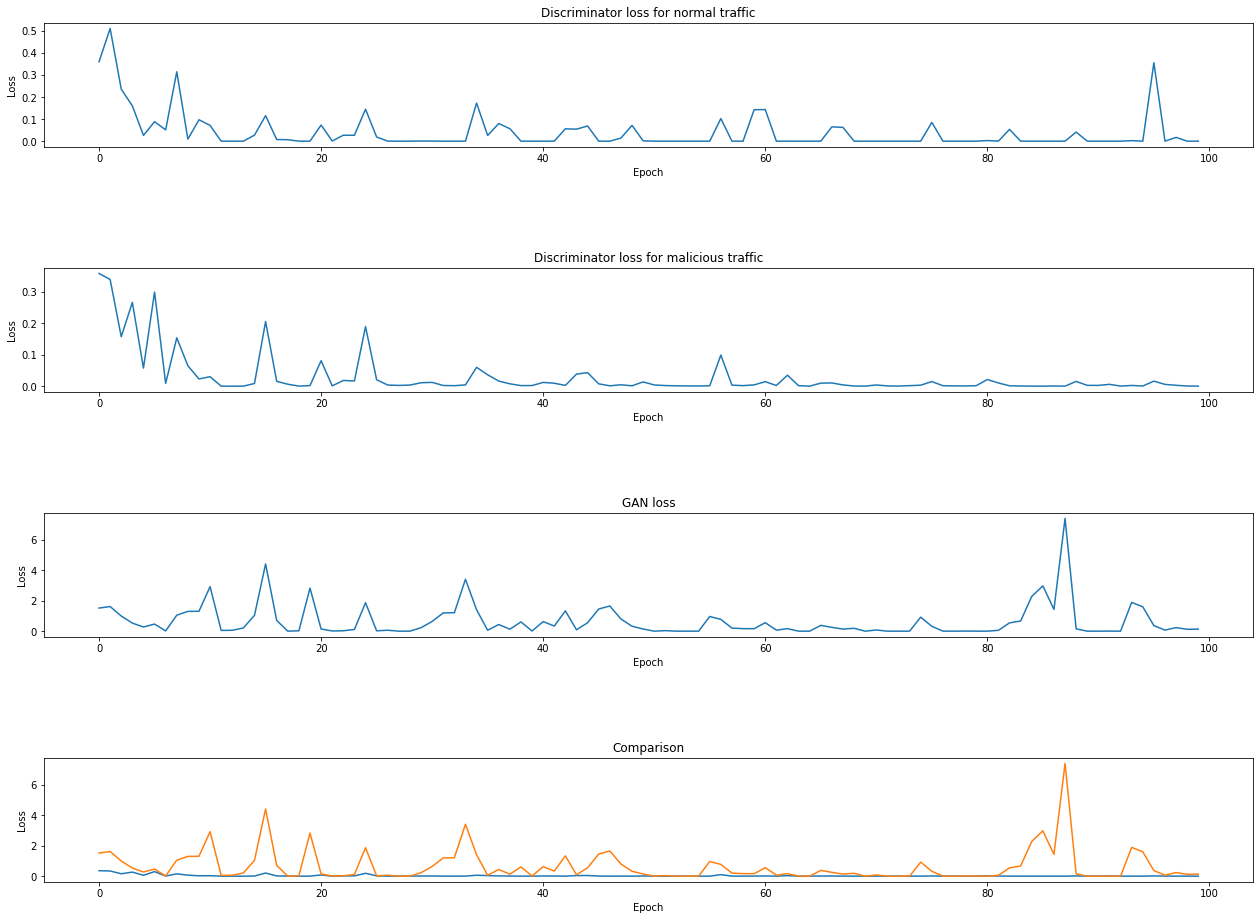

In [74]:
fig, axs = plt.subplots(4, 1, figsize=(20, 15))
fig.tight_layout(pad=10.0)

axs[0].set_title("Discriminator loss for normal traffic")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
sns.lineplot(x=list(disc_loss_normal_dict.keys()), y=list(disc_loss_normal_dict.values()), ax=axs[0])

axs[1].set_title("Discriminator loss for malicious traffic")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
sns.lineplot(x=list(disc_loss_mal_dict.keys()), y=list(disc_loss_mal_dict.values()), ax=axs[1])

axs[2].set_title("GAN loss")
axs[2].set_xlabel("Epoch")
axs[2].set_ylabel("Loss")
sns.lineplot(x=list(gan_loss_dict.keys()), y=list(gan_loss_dict.values()), ax=axs[2])

axs[3].set_title("Comparison")
axs[3].set_xlabel("Epoch")
axs[3].set_ylabel("Loss")
sns.lineplot(x=list(disc_loss_mal_dict.keys()), y=list(disc_loss_mal_dict.values()), ax=axs[3])
sns.lineplot(x=list(gan_loss_dict.keys()), y=list(gan_loss_dict.values()), ax=axs[3])

#### Orange: Generator loss<br>
#### Blue: Discriminator loss on malicious traffic

### Similarity 

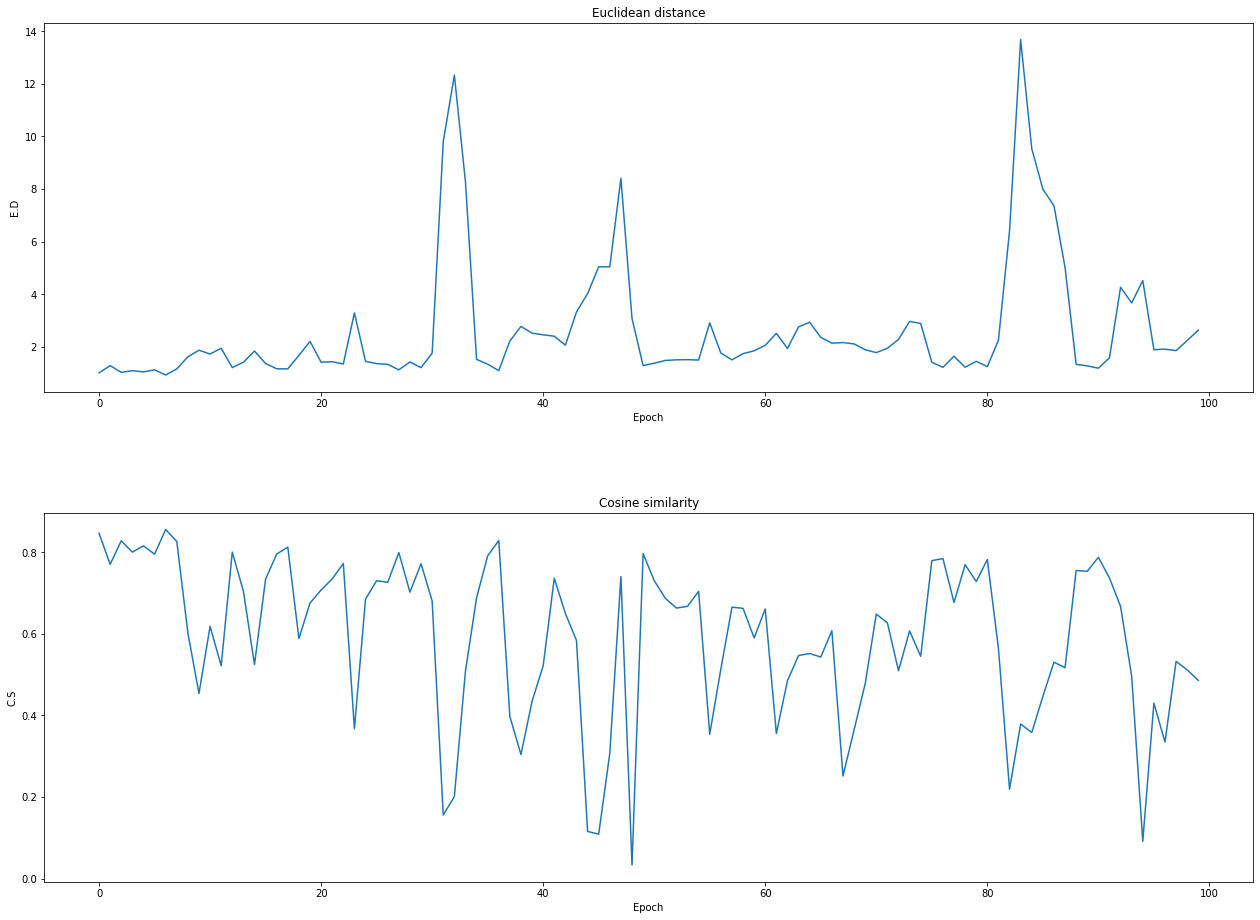

In [75]:
fig, axs = plt.subplots(2, 1, figsize=(20, 15))
fig.tight_layout(pad=10.0)

axs[0].set_title("Euclidean distance")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("E.D")
sns.lineplot(x=list(euc_dist_dict.keys()), y=list(euc_dist_dict.values()), ax=axs[0])

axs[1].set_title("Cosine similarity")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("C.S")
sns.lineplot(x=list(cosine_sim_dict.keys()), y=list(cosine_sim_dict.values()), ax=axs[1])